In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
import numpy as np

# Load the .npz file
data = np.load('pneumoniamnist.npz')

# Print what’s inside
print("Keys in the file:", data.files)

# Example: view shapes and first few items
for key in data.files:
    print(f"{key}: shape = {data[key].shape}")
    print(data[key][:5])  

Keys in the file: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
train_images: shape = (3882, 28, 28)
[[[ 92 108 117 ...   5   8   6]
  [129 138 141 ...   4   2   3]
  [141 146 148 ...   0   0   0]
  ...
  [168 180 192 ... 119 115 126]
  [173 184 195 ... 153 139 132]
  [173 185 198 ... 168 154 139]]

 [[115 118 117 ... 123 115 104]
  [130 137 140 ... 146 135 121]
  [134 151 167 ... 152 138 123]
  ...
  [176 180 187 ... 169 151 142]
  [181 185 192 ... 173 163 158]
  [184 189 195 ... 183 176 169]]

 [[149 146 147 ... 128 141 151]
  [171 153 147 ... 149 159 166]
  [172 166 167 ... 162 170 172]
  ...
  [ 95 133 174 ... 159 118 150]
  [139 166 196 ... 185 147 150]
  [181 184 191 ... 188 169 157]]

 [[110 100 101 ... 113 108  96]
  [113 113 118 ...  98 105 106]
  [113 124 129 ...  91 111 122]
  ...
  [166 167 169 ... 138 137 136]
  [169 170 171 ... 140 139 138]
  [169 170 172 ... 138 137 136]]

 [[115 118 126 ... 162 162 153]
  [153 143 140 ... 158

In [3]:
class PneumoniaMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.uint8)
        self.labels = labels.flatten().astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        # Convert grayscale to 3-channel
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [4]:
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = PneumoniaMNISTDataset(data['train_images'], data['train_labels'], transform=resize_transform)
val_dataset   = PneumoniaMNISTDataset(data['val_images'], data['val_labels'], transform=resize_transform)
test_dataset  = PneumoniaMNISTDataset(data['test_images'], data['test_labels'], transform=resize_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
model = models.inception_v3(pretrained=True, aux_logits=True)

# Freeze base
for param in model.parameters():
    param.requires_grad = False

# Train final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)


C:\Users\aarti\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aarti\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
# Compute class weights
unique, counts = np.unique(data['train_labels'], return_counts=True)
weights = 1.0 / counts
weights = torch.tensor(weights / weights.sum(), dtype=torch.float32).to(device)

# Use in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)


In [7]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

    torch.save(model.state_dict(), "inception_pneumonia.pt")
    print("✅ Model saved!")

train_model(model, train_loader, criterion, optimizer)


Epoch [1/5], Loss: 66.2028
Epoch [2/5], Loss: 49.3052
Epoch [3/5], Loss: 43.9618
Epoch [4/5], Loss: 39.3164
Epoch [5/5], Loss: 40.8804
✅ Model saved!


In [8]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


Classification Report:
              precision    recall  f1-score   support

      Normal       0.77      0.78      0.78       234
   Pneumonia       0.87      0.86      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624



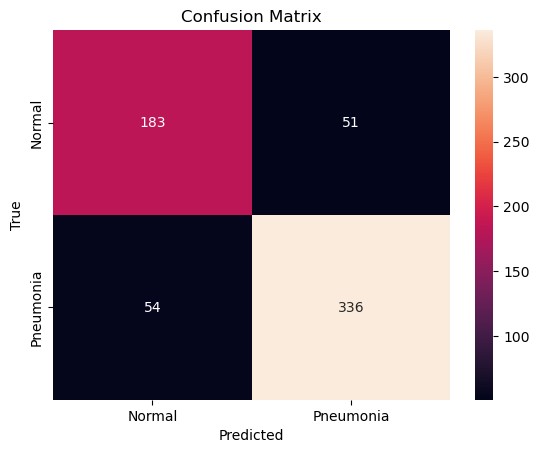

In [9]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
